<a href="https://colab.research.google.com/github/gjenov/HARMS/blob/main/roomTransition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.8/914.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
video_path = "/content/Nirveen 4.mp4"
output_path = "/content/Nirveen 4Ann.mp4"

In [ ]:
import cv2
import time
from ultralytics import YOLO
from datetime import datetime, timedelta

model = YOLO("yolo11n.pt")
model.overrides['verbose'] = False

#smaller video
#video_path = "/content/Nirveen_4Exit.mp4"
#output_path = "/content/Nirveen_4AnnExit.mp4"

#laying on bed
#video_path = "/content/laying_on_bed.mp4"
#output_path = "/content/laying_on_bed_Ann.mp4"


#4 min video
#video_path = "/content/Nirveen 4.mp4"
#output_path = "/content/Nirveen 4Ann.mp4"
cap = cv2.VideoCapture(video_path)


fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

                                          #changed from fps to 10 to compress
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

#rooms
test_boxes = [
    (660, 700, 1220, 350), #living room
    (0, 20, 1300, 300), #Kitchen
    (480, 380, 1430, 300), #Bedroom
    (0, 380, 470, 300) #Bathroom
    #(1450, 20, 460, 300) #stairs
]

room_colors = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0)

]

room_names = ["Living Room", "Kitchen", "Bedroom", "Bathroom"] ## add stairs


#actions
action_boxes = [
    (1568, 540, 250, 130), #sitting / laying on bed
     (673, 770, 200, 180), #sitting on couch
    (375, 45, 100, 200), # Fridge
    (170, 388, 180, 250) # sink
    #(0, 388, 150, 250)   #Shower
]

action_colors = [
    (255, 0, 0), #sitting / laying on bed
    (0, 0, 255), #sitting on couch
    (0, 0, 255),  #fridge
    (0, 0, 255)  #sink
    #(0, 255, 255)   #shower
]

action_names = ["Laying on Bed", "Sitting on Couch", "Fridge", "Sink"]#, "Shower"]






previous_room = None
previous_action = None
activity_list = []

#Insert Start Time here:
#12:34:10 for exit
#12:30:29 for whole video
start_time_input = "12:30:29"
start_time = datetime.strptime(start_time_input, "%H:%M:%S")

frame_count = 0

buffer_frames = 0
room_buffer = 0

room_buffer_threshold = 10
buffer_frames_threshold = 60
total_inf_time = 0.0
while cap.isOpened():

    success, frame = cap.read()

    if success:

        #time inference

        start_inf = time.perf_counter()
        results = model.track(frame, persist=True)
        end_inf = time.perf_counter()

        total_inf_time += end_inf - start_inf


        elapsed_seconds = frame_count / fps
        current_time = start_time + timedelta(seconds=elapsed_seconds)

        detected_room = None


        #for every "room"
        for idx, room_box in enumerate(test_boxes):
            person_in_room = False
            room_x, room_y, room_w, room_h = room_box
            room_color = room_colors[idx]
            room_name = room_names[idx]


            #check person box
            for box in results[0].boxes:
                if box.cls == 0:
                    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
                    #intersection
                    if (
                        x1 < room_x + room_w and x2 > room_x and
                        y1 < room_y + room_h and y2 > room_y
                    ):
                        person_in_room = True
                        detected_room = idx;
                        break

            # draw room
            cv2.rectangle(frame, (room_x, room_y), (room_x + room_w, room_y + room_h), room_color, 2)

            if person_in_room:
                cv2.putText(frame, f"Person in {room_name}", (room_x + 10, room_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


        #if there is no room present
            #incriment and check buffer frames,
            #if exceeded buffer frames


        if detected_room is not None:  # Room detected
            room_buffer += 1
            if detected_room != previous_room:  #different room detected
                if previous_room is not None:  # leave room and print previous
                    activity_list.append(f"Person Left {room_names[previous_room]} at {current_time.strftime('%H:%M:%S')}")
                    print(f"Person Left {room_names[previous_room]} at {current_time.strftime('%H:%M:%S')}")
                    previous_room = None

                # New Room
                if(room_buffer > room_buffer_threshold):
                    activity_list.append(f"Person Entered {room_names[detected_room]} at {current_time.strftime('%H:%M:%S')}")
                    print(f"Person Entered {room_names[detected_room]} at {current_time.strftime('%H:%M:%S')}")
                    previous_room = detected_room
                    room_buffer = 0


            # draw room
            cv2.rectangle(frame, (room_x, room_y), (room_x + room_w, room_y + room_h), room_color, 2)
            if person_in_room:
                cv2.putText(frame, f"Person in {room_name}", (room_x + 10, room_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)





        #ACTION CHECK
        action_idx = None
        for idx, action_box in enumerate(action_boxes):
              action_occured = False
              room_x, room_y, room_w, room_h = action_box
              action_color = action_colors[idx]
              action_name = action_names[idx]


              #check every person box
              for box in results[0].boxes:
                  if box.cls == 0:
                      x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

                      cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
                      #intersection
                      if (
                          x1 < room_x + room_w and x2 > room_x and
                          y1 < room_y + room_h and y2 > room_y
                      ):
                          action_occured = True
                          action_idx = idx;
                          break



        #this code is buggy, repeated entries or none at all at times, something to do with buffer_frames and not resetting
        if action_idx is not None:  # action detected
            buffer_frames = 0
            if action_idx != previous_action:  # New action
                if previous_action is not None:  #check if stopped
                    activity_list.append(f"Person stopped {action_names[previous_action]} at {current_time.strftime('%H:%M:%S')}")
                    print(f"Person stopped {action_names[previous_action]} at {current_time.strftime('%H:%M:%S')}")
                #started new action print
                activity_list.append(f"Person started {action_names[action_idx]} at {current_time.strftime('%H:%M:%S')}")
                print(f"Person started {action_names[action_idx]} at {current_time.strftime('%H:%M:%S')}")
                previous_action = action_idx


                # draw action
                cv2.rectangle(frame, (room_x, room_y), (room_x + room_w, room_y + room_h), action_color, 2)
                # If an action, display text
                if action_occured:
                    cv2.putText(frame, f"Person is {action_names[action_idx]}", (room_x + 10, room_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                buffer_frames = 0
        elif(previous_action is not None):
            buffer_frames += 1
            if (buffer_frames > buffer_frames_threshold):

                activity_list.append(f"Person stopped {action_names[previous_action]} at {current_time.strftime('%H:%M:%S')}")
                print(f"Person stopped {action_names[previous_action]} at {current_time.strftime('%H:%M:%S')}")
                buffer_frames = 0
                previous_action = action_idx




        out.write(frame)
        frame_count += 1

    else:

        break




cap.release()
out.release()

average_inference_time = total_inf_time / frame_count
fps = 1 / average_inference_time
print()
print(f"Average Inference Time: {average_inference_time}")
print(f"Frames per second: {fps:.2f}")

print(f"Output Video Path: {output_path}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 109MB/s]


requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.5s, installed 1 package: ['lap>=0.5.12']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Person Entered Living Room at 12:31:03
Person Left Living Room at 12:31:11
Person Entered Bedroom at 12:31:11
Person Left Bedroom at 12:31:26
Person Entered Bathroom at 12:31:26


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-a7ce8d3b861b>", line 103, in <cell line: 0>
    results = model.track(frame, persist=True)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 605, in track
    return self.predict(source=source, stream=stream, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 558, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
                                                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/predictor.py", line 175, 

In [ ]:
# 4:04 video
#6:03 of compute time
#takes about 1.5 times the length of the video to process
#For 1 hour of video = .144 (compute units) * .1 (10 cents per unit) * 1.5 = 0.0216 (2.16 cents per hour of footage for compute)

Frames per second (FPS): 22.61


In [ ]:
#Attempting to Compress for faster download

from google.colab import files
files.download(output_path)
#compressed_out = "/content/Nirveen 4AnnComp.mp4"
#!ffmpeg -i "{output_path}"  -vcodec libx264 -crf 10 -preset veryslow -acodec copy "{compressed_out}"



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
#xlsx implementation:
import pandas as pd
import openpyxl
from openpyxl.styles import PatternFill

# path
excel_file = "activity_log.xlsx"

wb = openpyxl.Workbook()
sheet = wb.active
sheet.title = "Activity Log"


room_colors = {
   # "Stairs": "FFCCCC",       #Red
    "Bedroom": "CCE5FF",      #Blue
    "Living Room": "D5E8D4",  #Green
    "Kitchen": "FFD6CC",      #Yellow
    "Bathroom": "FFF2CC"      #Orange
}

#header
sheet.append(["Activity", "Time"])


for entry in activity_list:

    parts = entry.split(' ')
    action = ' '.join(parts[1:3])  #modify later
    room = parts[2]
    if room == "Living":
      room += (" Room")
    timestamp = parts[-1]

    #new row
    row_index = sheet.max_row + 1
    sheet.append([action, timestamp])

    #Color each room
    if room in room_colors:
        color_fill = PatternFill(start_color=room_colors[room], end_color=room_colors[room], fill_type="solid")
        sheet.cell(row=row_index, column=1).fill = color_fill


wb.save(excel_file)
print(f"Exported to Path: {excel_file}")

pd.set_option('display.max_rows', None)
df = pd.read_excel(excel_file)
df

#Sheet Link
# https://docs.google.com/spreadsheets/d/141lPIqTSXwbAiwp7kO_BwdLTVhkbeS40g0s-MLq1Ck8/edit?usp=sharing

Exported to Path: activity_log.xlsx


,Activity,Time
0,Entered Living,12:31:03
1,started Sitting,12:31:05
2,stopped Sitting,12:31:08
3,Left Living,12:31:11
4,Entered Bedroom,12:31:11
5,started Laying,12:31:11
6,stopped Laying,12:31:21
7,Left Bedroom,12:31:26
8,Entered Bathroom,12:31:26
9,started Sink,12:31:26


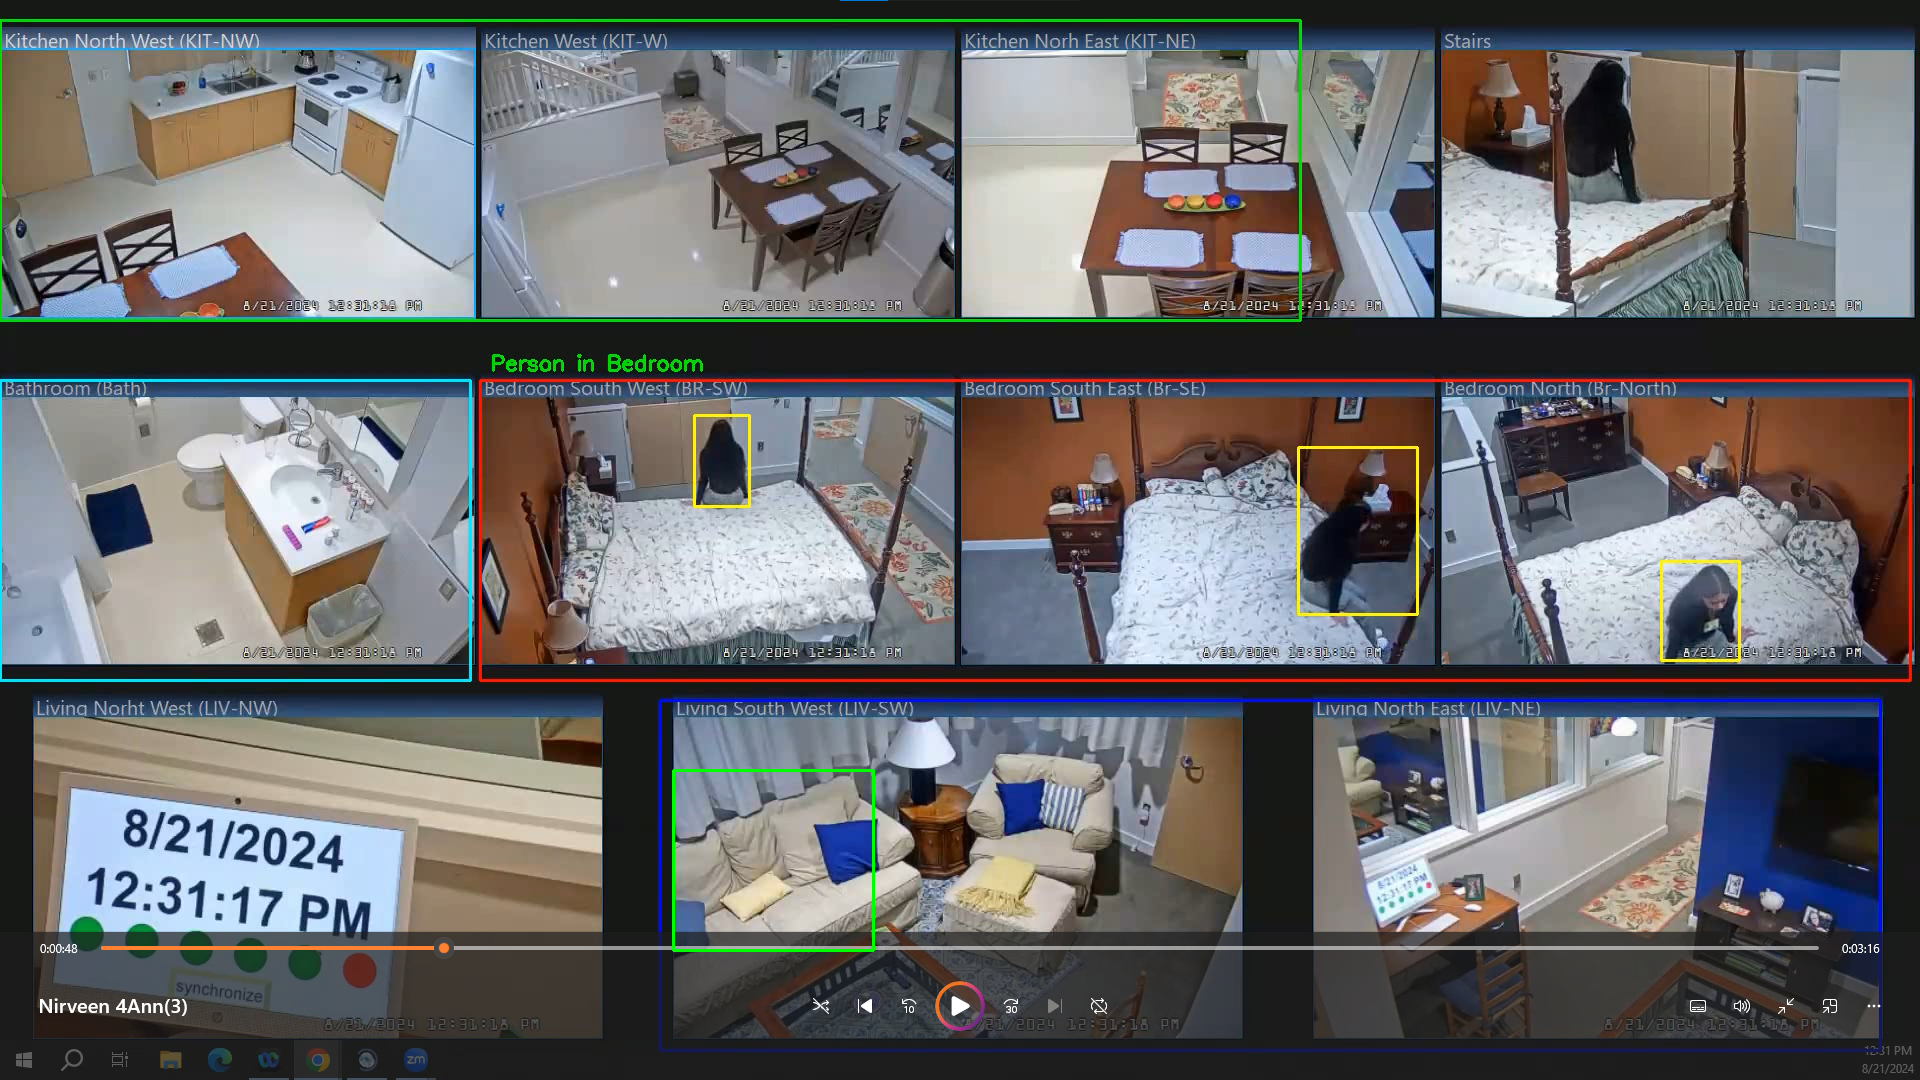

In [17]:
#test to line up bounding boxes

import cv2
from google.colab.patches import cv2_imshow
room_x, room_y, room_w, room_h = 150, 150, 150, 150
test_boxes = [
    #(660, 700, 1220, 350), #living room
    #(0, 20, 1300, 300) #Kitchen
    #(480, 380, 1430, 300), #Bedroom
    #(0, 380, 470, 300), #Bathroom
    #(1450, 20, 460, 300) #Stairs
    (673, 770, 200, 180) #sitting on couch
    #(375, 45, 100, 200) # Fridge
    #(170, 388, 180, 250) # sink
    #(0, 388, 150, 250)   #Shower
    #(1568, 540, 250, 130) #trouble with this one / laying on bed

]

def draw_boxes(image, boxes):
    for box in boxes:
        x, y, w, h = box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # Draw the room box in a different color

    return image

#input_path = 'tesimage.jpg'
input_path = 'sample.png'
image = cv2.imread(input_path)
overlay_image = draw_boxes(image.copy(), test_boxes)
cv2_imshow(overlay_image)